In [1]:
from base_layer_utils import BaseLayerDataRepo, BaseLayerResultsRepo, ModelName
from base_layer_utils import LightgbmBLE, OneVSOneRegBLE, SklearnBLE, NbSvmBLE, XGBoostBLE, RnnBLE

from fast_text_data import FastTextDataGenerator# fasttext_data_process
from tfidf_data import tfidf_data_process

import pandas as pd
import numpy as np
#from sklearn.cross_validation import KFold # replace with model_selection?
from sklearn.model_selection import KFold
import time
import gc
import xgboost as xgb
from sklearn.metrics import roc_auc_score

/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


loading FastText model...
fasttext model loaded. embedding dimemsion: 300


from tqdm import tqdm_notebook
import tqdm
import pandas as pd
import numpy as np
import re
import sklearn

#import seaborn as sns
#import matplotlib.pyplot as plt
%matplotlib inline

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC, LinearSVC



import re, time
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from scipy.sparse import csr_matrix, hstack

In [4]:
PATH = '~/data/toxic/data/'

train = pd.read_csv(PATH + 'cleaned_train.csv')
#train = pd.read_csv('/home/kai/data/wei/Toxic/data/Shiyi_training.csv').fillna('na')

test = pd.read_csv(PATH + 'cleaned_test.csv')

#train = train.head(1000)
#test = test.head(1000)

train_sentence = train['comment_text_cleaned']
test_sentence = test['comment_text_cleaned']

text = pd.concat([train_sentence, test_sentence])

print(train.shape)
print(test.shape)

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

(159571, 27)
(153164, 21)


train = train[:5000]
test = test[:5000]

# tfidf data

In [2]:
bldr = BaseLayerDataRepo()

In [3]:
x_train, y_train, x_test, data_id = tfidf_data_process(word_ngram=(1,1), word_max=100000)

loading data done!
fitting word
transforming train word
transforming test word


In [10]:
compatible_models= [ModelName.LSVC, ModelName.LOGREG, ]
bldr.add_data(data_id, x_train, y_train, x_test, label_cols, compatible_models)

In [11]:
print(bldr)

data_id: wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real 
	x_train: (159571, 300000)	x_test: (153164, 300000)
	y_train type: <class 'dict'>
	compatible_model: {<ModelName.NBSVM: 4>, <ModelName.NBLSVC: 7>}
 


# OOF

In [29]:
def get_oof(clf, x_train, y_train, x_test, nfolds, seed):
    #pdb.set_trace()
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))
    kf = KFold(ntrain, n_folds=nfolds, random_state=seed)
    

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        #pdb.set_trace()
        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [13]:
def get_oof_1v1(clf, x_train, y_train, x_test, nfolds, label, seed):
    #pdb.set_trace()
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((nfolds, ntest))
    kf = KFold(ntrain, n_folds=nfolds, random_state=seed) # seed is only useful if shuffle = True

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        #pdb.set_trace()
        clf.train(x_tr, y_tr, label)

        oof_train[test_index] = clf.predict(x_te, label)
        oof_test_skf[i, :] = clf.predict(x_test, label)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [11]:
def get_oof_rnn(clf, x_train, y_train, x_test, nfolds, number_labels, stratified=False, shuffle=True, seed=1001):
    """
    Params:
        shuffle: whether to shuffle in KFold.
        seed: random seed for shuffling. (set it for reproducing purpose)
    """
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    oof_train = np.zeros((ntrain,number_labels))
    oof_test = np.zeros((ntest,number_labels))
    oof_test_skf = np.empty((nfolds, ntest, number_labels))
    #kf = KFold(ntrain, n_folds=nfolds, random_state=seed)
    if stratified:
        kf = StratifiedKFold(n_splits=nfolds, shuffle=shuffle, random_state=seed)
    else:
        kf = KFold(n_splits=nfolds, shuffle=shuffle, random_state=seed)

    # tr_index, te_index: say there are four examples in training data(x_train, y_train)
    # index: 0,1,2,3. nfolds = 4. 
    # Then (when no shuffle): (the following is shown as an example. the actual may be different)
    #   in fold 1: tr_index = 1, 2, 3; tx_index = 0
    #   in fold 2: tr_index = 0, 2, 3; tx_index = 1
    #   in fold 3: tr_index = 0, 1, 3; tx_index = 2
    #   in fold 4: tr_index = 0, 1, 2, tx_index = 3
    # naming it as tr_index and te_index is because you training a model using tr_index 
    # and predict the tx_index to get out-of-fold predicions.
    for i, (tr_index, te_index) in enumerate(kf.split(x_train, y_train)):
        import pdb
        pdb.set_trace()
        x_tr, x_te = x_train[tr_index], x_train[te_index]
        y_tr, y_te = y_train.iloc[tr_index], y_train.iloc[te_index]
        
        
        clf.train(x_tr, y_tr, ft_data_gen, )
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :, :] = clf.predict(x_test)

#     for i, (train_index, test_index) in enumerate(kf):
#         ################################################################ maybe shuffle train_index
#         x_tr = x_train[train_index]
#         #pdb.set_trace()
#         y_tr = y_train.iloc[train_index]
#         x_te = x_train[test_index]
#         clf.train(x_tr, y_tr)

        

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train, oof_test

In [41]:
import gc
gc.collect()

7480

# Start generating oof_train, oof_test, baselayer estimater prediction and model data id list

In [6]:
def generate_base_layer_est_preds(base_layer_est_preds):
    for key in base_layer_est_preds:
        submission = pd.read_csv(PATH + 'sample_submission.csv')#.head(1000)
        submission[label_cols] = base_layer_est_preds[key]
        sub_id = int(time.time())
        print(sub_id)
        submission.to_csv('./BaseEstPreds/' + key + '_' + str(sub_id) + '.csv', index=False)

# RNN

In [5]:
x_test = FastTextDataGenerator.df_to_data(test, 'comment_text_cleaned', 200)

In [17]:
bldr = BaseLayerDataRepo()

# x_train_rnn, y_train_rnn, x_test_rnn, _, _ = fasttext_data_process()#first_n_entries=100)
#bldr.add_data(rnn_data_id, x_train_rnn, x_test_rnn, y_train_rnn, label_cols, compatible_models, True)

eps = 9
rnn_data_id = '_ep{}_fasttext_datagen_200_300'.format(eps)
compatible_models= [ModelName.RNN]
bldr.add_data(rnn_data_id, train['comment_text_cleaned'].values.reshape(-1,1), x_test, train[label_cols], label_cols, compatible_models, True)

print(bldr)

#bldr.add_compatible_model('wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real', ModelName.LGB)

for data in bldr.get_data_by_compatible_model(ModelName.LGB):
    print(data['compatible_model'])
    print(data['x_train'].shape)

data_id: _ep9_fasttext_datagen_200_300 
	x_train: (159571, 1)	x_test: (153164, 200, 300)
	y_train type: <class 'pandas.core.frame.DataFrame'>
	compatible_model: {<ModelName.RNN: 9>}
 


In [18]:
rnn_model_pool = {}

#x_train_rnn.shape[1], x_train_rnn.shape[2] 

rnn_ble = rnn_m = RnnBLE(200, 300, label_cols)#RnnBLE(x_train_rnn.shape[1], x_train_rnn.shape[2], label_cols, epochs=6)
rnn_model_pool[ModelName.RNN] = rnn_ble

In [19]:
import gc
gc.collect()

10479

In [20]:
base_layer_est_preds = {} # directly preditions from the base layer estimators

layer1_oof_train = {}
layer1_oof_test = {}

model_data_id_list = []

for model_name in rnn_model_pool.keys():
    for data in bldr.get_data_by_compatible_model(model_name):
        x_train = data['x_train']
        y_train = data['y_train']
        x_test = data['x_test']

        SEED = 1001 # for reproducibility
        NFOLDS = 4 # set folds for out-of-fold prediction
        #print(x_train.shape,y_train.shape,x_test.shape,label)

        current_run = '{} {}'.format(model_name,data['data_id'])
        print('Generating: '+current_run)

#         oof_train, oof_test = get_oof_rnn(rnn_model_pool[model_name], \
#                                           x_train, y_train, x_test, NFOLDS, len(label_cols), False, SEED)
#         for i, label in enumerate(label_cols):
#             if label not in layer1_oof_train:
#                 layer1_oof_train[label] = []
#                 layer1_oof_test[label] = []
#             layer1_oof_train[label].append(oof_train[:, i].reshape(-1,1)) # before reshape: (159571,) after: (159571, 1) => good for np.concatenate
#             layer1_oof_test[label].append(oof_test[:, i].reshape(-1,1))

        
        model_data_id = '{}_{}'.format(model_name, data['data_id'])
        model_data_id_list.append(model_data_id)
        model = rnn_model_pool[model_name]
        
        df_for_data_gen = pd.DataFrame(np.hstack((x_train, y_train)), columns=[['comment']+label_cols])
        ft_data_gen = FastTextDataGenerator(df_for_data_gen, label_cols, 'comment', 200, 32, True)
        
        temp_id = int(time.time())
        print('temp_id: ' + str(temp_id))
        model_file = 'obj/rnn_models/model_ep{}_{}'.format(eps, temp_id)
        checkpoint = ModelCheckpoint(model_file, monitor='acc', verbose=1)#, save_best_only=True, mode='min')
        #earlystopping = EarlyStopping(monitor="acc", mode="max", patience=2)
        callbacks = [checkpoint]#, earlystopping]
        
        model.train(1, data_gen=ft_data_gen.data_gen(), 
                    training_steps_per_epoch=ft_data_gen.training_steps_per_epoch, 
                    callbacks=callbacks, load_model=True, load_model_file='obj/rnn_models/model_ep8_1520451611')
        est_preds = model.predict(x_test)

        base_layer_est_preds[model_data_id] = est_preds

Generating: ModelName.RNN _ep9_fasttext_datagen_200_300
temp_id: 1520456363
load model: obj/rnn_models/model_ep8_1520451611
training with datagen
Epoch 1/1
1795/4987 [=========>....................] - ETA: 22:56 - loss: 0.0303 - acc: 0.9873

KeyboardInterrupt: 

In [16]:
generate_base_layer_est_preds(base_layer_est_preds)

1520454192


In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([106217.,   5191.,   3578.,   3145.,   2953.,   3032.,   3212.,
          3841.,   5201.,  16794.]),
 array([6.69230167e-06, 9.99994904e-02, 1.99992289e-01, 2.99985087e-01,
        3.99977885e-01, 4.99970683e-01, 5.99963481e-01, 6.99956279e-01,
        7.99949077e-01, 8.99941875e-01, 9.99934673e-01]),
 <a list of 10 Patch objects>)

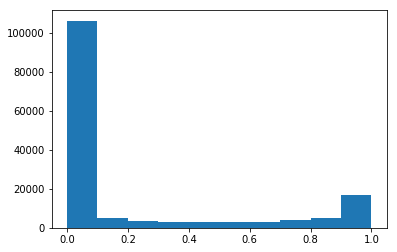

In [35]:
plt.hist(base_layer_est_preds['ModelName.RNN__ep2_fasttext_datagen_200_300'][:,0])

In [32]:
base_layer_est_preds['ModelName.RNN__ep2_fasttext_datagen_200_300'][:,0].shape

(153164,)

In [ ]:
base_layer_est_preds['ModelName.RNN_rnn_data_001'].shape

# 1VS1

In [14]:
onevsone_svc = OneVSOneReg(x_train_1v1, y_train_1v1, model='svc')
onevsone_logreg = OneVSOneReg(x_train_1v1, y_train_1v1)

OneVsOne is using svc kernel
calculating naive bayes for toxic
calculating naive bayes for severe_toxic
calculating naive bayes for obscene
calculating naive bayes for threat
calculating naive bayes for insult
calculating naive bayes for identity_hate
initializing done
OneVsOne is using svc kernel
OneVsOne is using logistic kernel
calculating naive bayes for toxic
calculating naive bayes for severe_toxic
calculating naive bayes for obscene
calculating naive bayes for threat
calculating naive bayes for insult
calculating naive bayes for identity_hate
initializing done
OneVsOne is using logistic kernel


In [15]:
model_pool = {}
model_pool[ModelName.ONESVC] = onevsone_svc
model_pool[ModelName.ONELOGREG] = onevsone_logreg

In [19]:
########################## ONE VS ONE ######################
base_layer_est_preds = {} # directly preditions from the base layer estimators

layer1_oof_train = {}
layer1_oof_test = {}

model_data_id_list = []

for i, label in enumerate(label_cols):
#     layer1_oof_train[label] = []
#     layer1_oof_test[label] = []
    for model_name in model_pool.keys():
        for data in bldr.get_data_by_compatible_model(model_name):
            x_train = data['x_train']
            y_train = data['y_train'][label]
            x_test = data['x_test']
            
            SEED = 0 # for reproducibility
            NFOLDS = 4 # set folds for out-of-fold prediction
            #print(x_train.shape,y_train.shape,x_test.shape,label)
            
            current_run = '{} {} {}'.format(model_name,data['data_id'],label)
            print('Generating: '+current_run)
            
            if model_name == ModelName.LGB:
                model = LogisticRegression(solver='sag')
                sfm = SelectFromModel(model, threshold='5*mean')
                print('dimension before selecting: train:{} test:{}'.format(x_train.shape, x_test.shape))
                x_train = sfm.fit_transform(x_train, y_train)
                x_test = sfm.transform(x_test)
                print('dimension after selecting: train:{} test:{}'.format(x_train.shape, x_test.shape))
            
            oof_train, oof_test = get_oof_1v1(model_pool[model_name],  x_train, y_train, x_test, NFOLDS, label, SEED) # Logreg
            if label not in layer1_oof_train:
                layer1_oof_train[label] = []
                layer1_oof_test[label] = []
            layer1_oof_train[label].append(oof_train)
            layer1_oof_test[label].append(oof_test)
            
            model_data_id = '{}_{}'.format(model_name, data['data_id'])
            model = model_pool[model_name]
            model.train(x_train, y_train, label)
            est_preds = model.predict(x_test, label)
            
            if model_data_id not in base_layer_est_preds:
                base_layer_est_preds[model_data_id] = np.empty((x_test.shape[0],len(label_cols)))
                model_data_id_list.append(model_data_id)
            base_layer_est_preds[model_data_id][:,i] = est_preds

Generating: ModelName.ONESVC wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real toxic
Starting One vs One dataset splitting
splitting done!
start training linear svc regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training linear svc regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training linear svc regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training linear svc regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One datase

predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training logistic regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training logistic regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training logistic regression
training done
applying naive bayes to dataset
predicting
predicting done
applying naive bayes to dataset
predicting
predicting done
Starting One vs One dataset splitting
splitting done!
start training logistic regression
training done
applying naive bayes to dataset
predicting
predicting done
Generating: ModelName.ONESVC wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real insult
Starting One vs One dataset splitting
splitting done!
start train

# Normal Models

In [57]:
import lightgbm as lgb

In [ ]:
lgb.train()

In [59]:
model_pool = {}

SEED = 0

# logreg_params = {
#     'n_jobs': 3
# }
# logreg_ble = SklearnBLE(LogisticRegression, seed=SEED, params=logreg_params)
# model_pool[ModelName.LOGREG] = logreg_ble


#rf_ble = SklearnBLE(RandomForestClassifier, seed=SEED, params={'n_jobs': 3})
#model_pool[ModelName.RF] = rf_ble


# nblsvc_params = {
#     'C':0.02
# }
# nblsvc_ble = NbSvmBLE(mode=ModelName.NBLSVC, seed=SEED, params=nblsvc_params)
# model_pool[ModelName.NBLSVC] = nblsvc_ble


# nbsvm_params = {
#     'C':0.25,
#     #'dual':True,
#     'n_jobs':5
# }
# nbsvm_ble = NbSvmBLE(mode=ModelName.NBSVM, seed=SEED, params=nbsvm_params)
# model_pool[ModelName.NBSVM] = nbsvm_ble

#rf_ble = SklearnBLE(RandomForestClassifier, seed=SEED, params={})
#xgb_ble = XgbBLE(params=xgb_params)

lgb_params = {
    #'learning_rate': 0.05,
    'is_unbalance': True,
    'early_stopping_round': 25,
    'max_depth': -1,
    'num_boost_round': 3000,
    'application': 'binary',
    'num_leaves': 31,
    'verbosity': 1,
    'metric': 'auc',
    'data_random_seed': 2,
    'bagging_fraction': 1,
    'feature_fraction': 0.6,
    'nthread': 14
#     'lambda_l1': 1,
#     'lambda_l2': 1
}
lgb_ble = LightgbmBLE(x_train_1v1, y_train_1v1, params=lgb_params, nb=False)
model_pool[ModelName.LGB] = lgb_ble


# lg = SklearnBLE(clf=LogisticRegression, seed=SEED, params={'n_jobs': 1})

# et = SklearnBLE(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
# ada = SklearnBLE(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
# gb = SklearnBLE(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
# svc = SklearnBLE(clf=SVC, seed=SEED, params=svc_params)

#model_pool['rf'] = rf_ble

Naive Bayes is disabled
LightgbmBLE is initialized


In [61]:
########################## NORMAL MODELS ######################
base_layer_est_preds = {} # directly preditions from the base layer estimators

layer1_oof_train = {}
layer1_oof_test = {}

model_data_id_list = []

for i, label in enumerate(label_cols):
#     layer1_oof_train[label] = []
#     layer1_oof_test[label] = []
    for model_name in model_pool.keys():
        for data in bldr.get_data_by_compatible_model(model_name):
            x_train = data['x_train']
            y_train = data['y_train'][label]
            x_test = data['x_test']
            
            SEED = 0 # for reproducibility
            NFOLDS = 4 # set folds for out-of-fold prediction
            #print(x_train.shape,y_train.shape,x_test.shape,label)
            
            current_run = '{} {} {}'.format(model_name,data['data_id'],label)
            print('Generating: '+current_run)
            
#             if model_name == ModelName.LGB:
#                 model = LogisticRegression(solver='sag')
#                 sfm = SelectFromModel(model, threshold='5*mean')
#                 print('dimension before selecting: train:{} test:{}'.format(x_train.shape, x_test.shape))
#                 x_train = sfm.fit_transform(x_train, y_train)
#                 x_test = sfm.transform(x_test)
#                 print('dimension after selecting: train:{} test:{}'.format(x_train.shape, x_test.shape))
            
            oof_train, oof_test = get_oof(model_pool[model_name],  x_train, y_train, x_test, NFOLDS, SEED) # Logreg
            if label not in layer1_oof_train:
                layer1_oof_train[label] = []
                layer1_oof_test[label] = []
            layer1_oof_train[label].append(oof_train)
            layer1_oof_test[label].append(oof_test)
            
            model_data_id = '{}_{}'.format(model_name, data['data_id'])
            model = model_pool[model_name]
            model.train(x_train, y_train)
            est_preds = model.predict(x_test)
            
            if model_data_id not in base_layer_est_preds:
                base_layer_est_preds[model_data_id] = np.empty((x_test.shape[0],len(label_cols)))
                model_data_id_list.append(model_data_id)
            base_layer_est_preds[model_data_id][:,i] = est_preds

Generating: ModelName.LGB wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real toxic


/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/lightgbm/engine.py:99: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/kai/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/lightgbm/engine.py:104: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 25 rounds.
[20]	valid_0's auc: 0.94673
[40]	valid_0's auc: 0.9676
[60]	valid_0's auc: 0.978568
[80]	valid_0's auc: 0.984588
[100]	valid_0's auc: 0.988221
[120]	valid_0's auc: 0.990593
[140]	valid_0's auc: 0.992301


KeyboardInterrupt: 

### submit the base layer estimator predictions. If they look fine, save them to BaseLayerResultsRepo

In [24]:
model_data_id_list

['ModelName.RNN_rnn_data_fasttext_200_300']

In [25]:
list(base_layer_est_preds)

['ModelName.RNN_rnn_data_fasttext_200_300']

In [26]:
list(layer1_oof_train) # list keys

['toxic', 'threat', 'obscene', 'identity_hate', 'severe_toxic', 'insult']

In [27]:
len(layer1_oof_train['toxic']) # number of models to stack (each model will predict one set of toxic, servere_toxic, etc..)

1

In [28]:
len(layer1_oof_train['toxic'][0]) # examples in oof_train (meta features, x_train) (meta labels are in train[label])

159571

In [29]:
list(layer1_oof_test)

['toxic', 'threat', 'obscene', 'identity_hate', 'severe_toxic', 'insult']

In [30]:
len(layer1_oof_test['toxic'][0]) # examples in oof_test (will be used by meta model (after validation) to predict the final prediction)

153164

In [35]:
base_layer_results_repo = BaseLayerResultsRepo()#load_from_file=False)

load from file


In [36]:
scores = base_layer_results_repo.show_scores()

0.9827	ModelName.NBLSVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9825	ModelName.RNN_rnn_data_001
0.9818	ModelName.ONELOGREG_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9815	ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9803	ModelName.NBSVM_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9794	ModelName.LGB_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9793	ModelName.LOGREG_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9786	ModelName.ONESVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w
0.9774	ModelName.NBLSVC_tfidf_word_df2_ng(1, 1)_wmf200000
0.9768	ModelName.NBSVM_tfidf_word_df2_ng(1, 1)_wmf200000
0.9765	ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000
0.9761	ModelName.NBSVM_tfidf_word_df2_ng(1, 2)_wmf200000
0.976	ModelName.LOGREG_tfidf_word_df2_ng(1, 1)_wmf200000
0.9752	ModelName.LOGREG_tfidf_word_df2_ng(1, 2)_wmf200000
0.9726	ModelName.LGB_tfidf_word_df2_ng(1, 2)_wmf200000
0.9723	ModelNam

base_layer_results_repo.add(layer1_oof_train, layer1_oof_test, base_layer_est_preds, model_data_id_list)

In [ ]:
base_layer_results_repo.add_score('ModelName.NBSVM_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real', 0.9826)

In [34]:
base_layer_results_repo.save()

### before we choose which models to assemble, we can do:
#### 1. scatter plot analysis to check the diversity
#### 2. submit to check if the models have similar performance

## Ensembling:

In [13]:
def combine_layer_oof_per_label(layer1_oof_dict, label):
    x = None
    data_list = layer1_oof_dict[label]
    for i in range(len(data_list)):
        if i == 0:
            x = data_list[0]
        else:
            x = np.concatenate((x, data_list[i]), axis=1)
    return x

### 1. simple blend of two models

result = np.empty((test.shape[0],len(label_cols)))

# mix the first two models
for i, label in enumerate(label_cols):
    x_train = combine_layer_oof_per_label(layer1_oof_train, label)
    x_test = combine_layer_oof_per_label(layer1_oof_test, label)
    for j in range(x_train.shape[1]):
        roc = roc_auc_score(train[label], x_train[:,j])
        print(label, j, roc) # print out roc for meta feature on meta label (which is just the original train label)
    
    roc_scores_of_a_label = []
    alphas = np.linspace(0,1,1001)
    best_roc = 0
    best_alpha = 0
    for alpha in alphas:
        roc = roc_auc_score(train[label], alpha*x_train[:,0] + (1-alpha)*x_train[:,1])
        if roc > best_roc:
            best_roc = roc
            best_alpha = alpha
    
    print(label, best_roc, best_alpha)
    result[:,i] = best_alpha*x_test[:,0] + (1-best_alpha)*x_test[:,1]

submission = pd.read_csv(PATH + 'sample_submission.csv')#.head(1000)
submission[label_cols] = result
sub_id = int(time.time())
print(sub_id)
submission.to_csv('./StackPreds/mixtwo_' + str(sub_id) + '.csv', index=False)

### 2. stacking

In [151]:
list(layer1_oof_train)

['insult', 'toxic', 'obscene', 'threat', 'severe_toxic', 'identity_hate']

In [4]:
base_layer_results_repo = BaseLayerResultsRepo()

load from file


In [7]:
base_layer_results_repo.add_score('ModelName.NBSVM_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real',0.09826)

ModelName.NBSVM_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real already existed in the repo. score: 0.9826 update to 0.09826


In [8]:
scores = base_layer_results_repo.show_scores()

0.9827	ModelName.NBLSVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9825	ModelName.RNN_rnn_data_001
0.9818	ModelName.ONELOGREG_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9815	ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9803	ModelName.NBSVM_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9794	ModelName.LGB_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9793	ModelName.LOGREG_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9786	ModelName.ONESVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w
0.9774	ModelName.NBLSVC_tfidf_word_df2_ng(1, 1)_wmf200000
0.9768	ModelName.NBSVM_tfidf_word_df2_ng(1, 1)_wmf200000
0.9765	ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000
0.9761	ModelName.NBSVM_tfidf_word_df2_ng(1, 2)_wmf200000
0.976	ModelName.LOGREG_tfidf_word_df2_ng(1, 1)_wmf200000
0.9752	ModelName.LOGREG_tfidf_word_df2_ng(1, 2)_wmf200000
0.9726	ModelName.LGB_tfidf_word_df2_ng(1, 2)_wmf200000
0.9723	ModelNam

In [10]:
ths = [score for _, score in scores][3:10]

In [11]:
ths

[0.9815, 0.9803, 0.9794, 0.9793, 0.9786, 0.9774, 0.9768]

In [29]:
#base_layer_results_repo.add_score('ModelName.ONELOGREG_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real',0.9818)

ModelName.ONELOGREG_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real already existed in the repo. score: 0 update to 0.9818


In [12]:
train.shape

NameError: name 'train' is not defined

f = open('./xgb_search.csv', 'a')
# header = 'time,id,th,amt,csbt,lr,md,ss,ga,a,rounds,folds,tops,sps,ops,\
# thps,inps,ihps,tobr,sbr,obr,thbr,inbr,ihbr,sth1,sth2,sth3,sth4,sth5,\
# to_auc,s_auc,o_auc,th_auc,in_auc,ih_auc,avg_auc\n'
header = 'time,id,threshold,num_models,colsample_bytree,lr,max_depth,subsample,\
gamma,alpha,cv_num_round,cv_nfolds,toxic_pos_scale,severe_toxic_pos_scale,obscene_pos_scale,\
threat_pos_scale,insult_pos_scale,identity_hate_pos_scale,sth1,sth2,sth3,sth4,sth5,\
toxic_best_round,severe_toxic_best_round,obscene_best_round,threat_best_round,\
insult_best_round,identity_hate_best_round,toxic_auc,severe_toxic_auc,obscene_auc,\
threat_auc,insult_auc,identity_hate_auc,avg_auc\n'
f.write(header)
f.close()

In [4]:
def get_time():
    from datetime import datetime
    from dateutil import tz

    # METHOD 1: Hardcode zones:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')


    utc = datetime.utcnow()

    # Tell the datetime object that it's in UTC time zone since 
    # datetime objects are 'naive' by default
    utc = utc.replace(tzinfo=from_zone)

    # Convert time zone
    est = utc.astimezone(to_zone)
    
    return est.strftime('%Y-%m-%d %H:%M:%S')

In [ ]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import cross_val_score

for i in range(130):
    now = get_time()
    search_id = int(time.time())
    np.random.seed(int(time.time()* 1000000) % 45234634)
    
    model_threshold = np.random.choice(ths)#[0.9803, 0.9794, 0.9793, 0.9786, 0.9774, 0.9768, 0.9765])
    layer1_oof_train_loaded, layer1_oof_test_loaded, base_layer_est_preds_loaded = base_layer_results_repo.get_results(threshold=model_threshold)
    gc.collect() 
        
    xgb_colsample_bytree = np.random.randint(5, 10)/10
    xgb_learning_rate = 1e-2 * (0.1 ** (np.random.rand() * 2 - 1.0)) # 0.001 to 0.0997
    xgb_max_depth = np.random.randint(2, 8)
    xgb_subsample = np.random.randint(50, 100)/100
    xgb_gamma = np.random.randint(0, 3)
    xgb_alpha = np.random.randint(0, 2)

    xgb_cv_seed = 0
    xgb_cv_num_round = np.random.randint(400, 1000)
    xgb_cv_nfolds = np.random.randint(3,5)
    
    scale_pos_weights = {}
    scale_pos_weights['toxic'] = np.random.randint(2, 15) #10
    scale_pos_weights['severe_toxic'] = np.random.randint(20, 130) # 100
    scale_pos_weights['obscene'] = np.random.randint(3, 25) # 17
    scale_pos_weights['threat'] = np.random.randint(60, 380) # 333
    scale_pos_weights['insult'] = np.random.randint(4, 25) # 20
    scale_pos_weights['identity_hate'] = np.random.randint(30, 140) #112

    xgb_params = {
        'seed': 0,
        'colsample_bytree': xgb_colsample_bytree,
        'silent': 1,
        'subsample': xgb_subsample,
        'learning_rate': xgb_learning_rate,
        'max_depth': xgb_max_depth,
        'gamma': xgb_gamma,
        'alpha': xgb_alpha,
        'nthread': 5,
        'min_child_weight': 1,
        'objective':'binary:logistic',
        'eval_metric':'auc'
    }

    num_models = len(layer1_oof_train_loaded['toxic'])
    #print('Stacking {} models'.format(num_models)) # number of models that will be stacked

    print('time: %s, id: %d, th: %f, num_models: %d, colsample_bytree: %f, lr: %.7f, \
    max_depth: %d, subsample: %f, gamma: %d, alpha: %d, cv_num_round: %d, cv_nfolds: %d,\
    to_pw: %d, s_pw: %d, ob_pw: %d, th_pw: %d, in_pw: %d, ih_pw: %d\
            '%(now,search_id,model_threshold,num_models,\
              xgb_colsample_bytree,xgb_learning_rate,\
              xgb_max_depth,xgb_subsample,xgb_gamma,\
              xgb_alpha,xgb_cv_num_round,xgb_cv_nfolds,\
              scale_pos_weights['toxic'],scale_pos_weights['severe_toxic'],\
              scale_pos_weights['obscene'],scale_pos_weights['threat'],\
              scale_pos_weights['insult'],scale_pos_weights['identity_hate']))
    

    result = np.empty((test.shape[0],len(label_cols)))
    metric_dict = {} # all labels
    best_nrounds = {}  # all labels

    for i, label in enumerate(label_cols):
        assert train.shape == (159571, 27)
        x_train = combine_layer_oof_per_label(layer1_oof_train_loaded, label)
        x_test = combine_layer_oof_per_label(layer1_oof_test_loaded, label)

    #     clf = XGBClassifier()
    #     #scores = cross_val_score(clf, x_train, train[label], cv=3, scoring='roc_auc')
    #     #print(scores)
    #     #print("Stacking-CV: ROC: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #     clf.fit(x_train, train[label])
    #     result[:, i] = clf.predict_proba(x_test)[:,1]

        dtrain = xgb.DMatrix(x_train, train[label]) # check if train is still in right shape
        dtest = xgb.DMatrix(x_test)

        def xg_eval_auc(yhat, dtrain):
            y = dtrain.get_label()
            return 'auc', roc_auc_score(y, yhat)

        xgb_params['scale_pos_weight'] = scale_pos_weights[label]
        
        res = xgb.cv(xgb_params, dtrain, num_boost_round=xgb_cv_num_round, nfold=xgb_cv_nfolds, seed=xgb_cv_seed, stratified=False,
                 early_stopping_rounds=25, verbose_eval=None, show_stdv=False, feval=xg_eval_auc, maximize=True)
        # early stopping is based on eavl on test fold. so check out the test-auc
        #pdb.set_trace()
        best_nrounds_for_current_label = res.shape[0] - 1
        #print(res[-3:])
        cv_mean = res.iloc[-1, 0]
        cv_std = res.iloc[-1, 1]

        #print('Ensemble-CV: {}: {}+{}'.format(label, cv_mean, cv_std))
        metric_dict[label] = cv_mean
        best_nrounds[label] = best_nrounds_for_current_label
        #metric_dict[label]['cv_mean'] = cv_mean
        #metric_dict[label]['cv_std'] = cv_std
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds_for_current_label)

        result[:,i] = gbdt.predict(dtest)#_proba(x_test)[:,1]

    #print('Stacking done')

    avg_auc = 0
    for label in label_cols:
        avg_auc += metric_dict[label]
    avg_auc/=6
          
    res = '%s,%d,%f,%d,%f,%.7f,%d,%f,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%d,%.8f,%.8f,%.8f,%.8f,%.8f,%.8f,%.8f\n\
            '%(now,search_id,model_threshold,num_models,xgb_colsample_bytree,\
               xgb_learning_rate,xgb_max_depth,xgb_subsample,xgb_gamma,xgb_alpha,\
               xgb_cv_num_round,xgb_cv_nfolds,scale_pos_weights['toxic'],scale_pos_weights['severe_toxic'],\
               scale_pos_weights['obscene'],scale_pos_weights['threat'],scale_pos_weights['insult'],\
               scale_pos_weights['identity_hate'],-99,-99,-99,-99,-99,best_nrounds['toxic'],best_nrounds['severe_toxic'],\
               best_nrounds['obscene'],best_nrounds['threat'],best_nrounds['insult'],\
               best_nrounds['identity_hate'],metric_dict['toxic'],metric_dict['severe_toxic'],\
               metric_dict['obscene'],metric_dict['threat'],metric_dict['insult'],\
               metric_dict['identity_hate'],avg_auc)

    f = open('./xgb_search.csv', 'a')
    f.write(res)
    f.close()

#     sub_tile = 'stacking_test_'
#     submission = pd.read_csv(PATH + 'sample_submission.csv')#.head(1000)
#     submission[label_cols] = result
#     submission.to_csv('./StackPreds/' + sub_tile + str(search_id) + '.csv', index=False)

time: 2018-03-02 00:25:50, id: 1519968350, th: 0.980300, num_models: 5, colsample_bytree: 0.700000, lr: 0.0152982,     max_depth: 4, subsample: 0.690000, gamma: 2, alpha: 0, cv_num_round: 633, cv_nfolds: 4,    to_pw: 6, s_pw: 74, ob_pw: 14, th_pw: 139, in_pw: 10, ih_pw: 128            
time: 2018-03-02 00:34:34, id: 1519968874, th: 0.981500, num_models: 4, colsample_bytree: 0.500000, lr: 0.0105918,     max_depth: 4, subsample: 0.670000, gamma: 1, alpha: 0, cv_num_round: 729, cv_nfolds: 4,    to_pw: 7, s_pw: 121, ob_pw: 23, th_pw: 292, in_pw: 21, ih_pw: 42            
time: 2018-03-02 00:40:43, id: 1519969243, th: 0.979300, num_models: 7, colsample_bytree: 0.700000, lr: 0.0027763,     max_depth: 4, subsample: 0.810000, gamma: 0, alpha: 1, cv_num_round: 471, cv_nfolds: 3,    to_pw: 7, s_pw: 52, ob_pw: 24, th_pw: 251, in_pw: 13, ih_pw: 118            
time: 2018-03-02 00:44:33, id: 1519969473, th: 0.979300, num_models: 7, colsample_bytree: 0.500000, lr: 0.0010538,     max_depth: 7, subsam

time: 2018-03-02 03:22:59, id: 1519978979, th: 0.979300, num_models: 7, colsample_bytree: 0.500000, lr: 0.0685323,     max_depth: 2, subsample: 0.880000, gamma: 2, alpha: 1, cv_num_round: 984, cv_nfolds: 4,    to_pw: 8, s_pw: 87, ob_pw: 11, th_pw: 93, in_pw: 10, ih_pw: 109            
time: 2018-03-02 03:31:54, id: 1519979514, th: 0.976800, num_models: 10, colsample_bytree: 0.900000, lr: 0.0392708,     max_depth: 5, subsample: 0.630000, gamma: 0, alpha: 0, cv_num_round: 498, cv_nfolds: 4,    to_pw: 11, s_pw: 121, ob_pw: 23, th_pw: 351, in_pw: 23, ih_pw: 57            
time: 2018-03-02 03:37:12, id: 1519979832, th: 0.977400, num_models: 9, colsample_bytree: 0.700000, lr: 0.0030536,     max_depth: 6, subsample: 0.700000, gamma: 0, alpha: 1, cv_num_round: 873, cv_nfolds: 4,    to_pw: 4, s_pw: 114, ob_pw: 7, th_pw: 341, in_pw: 4, ih_pw: 118            
time: 2018-03-02 03:45:08, id: 1519980308, th: 0.978600, num_models: 8, colsample_bytree: 0.600000, lr: 0.0649149,     max_depth: 7, subsam

time: 2018-03-02 07:15:18, id: 1519992918, th: 0.980300, num_models: 5, colsample_bytree: 0.600000, lr: 0.0010395,     max_depth: 7, subsample: 0.840000, gamma: 1, alpha: 1, cv_num_round: 695, cv_nfolds: 4,    to_pw: 4, s_pw: 85, ob_pw: 23, th_pw: 341, in_pw: 9, ih_pw: 105            
time: 2018-03-02 07:21:05, id: 1519993265, th: 0.979400, num_models: 6, colsample_bytree: 0.800000, lr: 0.0032795,     max_depth: 2, subsample: 0.860000, gamma: 1, alpha: 1, cv_num_round: 544, cv_nfolds: 3,    to_pw: 9, s_pw: 43, ob_pw: 9, th_pw: 69, in_pw: 19, ih_pw: 61            
time: 2018-03-02 07:28:58, id: 1519993738, th: 0.981500, num_models: 4, colsample_bytree: 0.500000, lr: 0.0188473,     max_depth: 3, subsample: 0.940000, gamma: 2, alpha: 0, cv_num_round: 405, cv_nfolds: 3,    to_pw: 14, s_pw: 114, ob_pw: 17, th_pw: 344, in_pw: 24, ih_pw: 30            
time: 2018-03-02 07:35:41, id: 1519994141, th: 0.977400, num_models: 9, colsample_bytree: 0.800000, lr: 0.0688231,     max_depth: 2, subsample

# xgb random search top N training

In [5]:
from base_layer_results_repo import BaseLayerResultsRepo

In [6]:
base_layer_results_repo = BaseLayerResultsRepo()

load from file


In [7]:
scores = base_layer_results_repo.show_scores()

0.9827	ModelName.NBLSVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9825	ModelName.RNN_rnn_data_001
0.9818	ModelName.ONELOGREG_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w_real
0.9815	ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9803	ModelName.NBSVM_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9794	ModelName.LGB_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9793	ModelName.LOGREG_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000
0.9786	ModelName.ONESVC_wordtfidf_ng13_mf10w_chartfidf_ng25_mf20w
0.9774	ModelName.NBLSVC_tfidf_word_df2_ng(1, 1)_wmf200000
0.9768	ModelName.NBSVM_tfidf_word_df2_ng(1, 1)_wmf200000
0.9765	ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000
0.9761	ModelName.NBSVM_tfidf_word_df2_ng(1, 2)_wmf200000
0.976	ModelName.LOGREG_tfidf_word_df2_ng(1, 1)_wmf200000
0.9752	ModelName.LOGREG_tfidf_word_df2_ng(1, 2)_wmf200000
0.9726	ModelName.LGB_tfidf_word_df2_ng(1, 2)_wmf200000
0.9723	ModelNam

In [10]:
xgb_search = pd.read_csv('xgb_search.csv').sort_values(by='avg_auc', ascending=False)

xgb_search.head(3)

,time,id,threshold,num_models,colsample_bytree,lr,max_depth,subsample,gamma,alpha,...,threat_best_round,insult_best_round,identity_hate_best_round,toxic_auc,severe_toxic_auc,obscene_auc,threat_auc,insult_auc,identity_hate_auc,avg_auc
9,2018-03-02 00:54:48,1519970088,0.9794,6,0.9,0.096663,3,0.90,2,0,...,119,74,98,0.987579,0.991802,0.995448,0.994074,0.990130,0.991359,0.991732
73,2018-03-02 08:36:45,1519997805,0.9768,10,0.7,0.031006,4,0.90,1,0,...,273,163,195,0.987640,0.991029,0.995461,0.993971,0.990103,0.991239,0.991574
65,2018-03-02 07:35:41,1519994141,0.9774,9,0.8,0.068823,2,0.65,2,1,...,100,96,104,0.987659,0.991810,0.995460,0.992785,0.990203,0.991231,0.991525


In [11]:
xgb_search_round1 = pd.read_csv('xgb_search_ori100.csv').sort_values(by='avg_auc', ascending=False)

xgb_search_round1.head(3)

,time,id,threshold,num_models,colsample_bytree,lr,max_depth,subsample,gamma,alpha,cv_num_round,cv_nfolds,toxic_auc,severe_toxic_auc,obscene_auc,threat_auc,insult_auc,identity_hate_auc,avg_auc
0,2018-03-01 10:23:13,1519899793,0.9768,10,0.7,0.092125,2,0.85,2,0,962,4,0.987677,0.991848,0.995462,0.994002,0.990178,0.991174,0.991723
1,2018-03-01 06:45:20,1519886720,0.9794,6,0.8,0.097664,4,0.68,1,0,995,3,0.987663,0.991693,0.995412,0.993793,0.990062,0.991191,0.991636
2,2018-03-01 08:14:47,1519892087,0.9794,6,0.5,0.098587,3,0.77,1,0,809,4,0.987629,0.991796,0.995422,0.993610,0.990133,0.991218,0.991635


In [17]:
for i in range(3):
    
    now = get_time()

    search_id = xgb_search['id'].values[i]
    model_threshold = xgb_search['threshold'].values[i]
    num_models = xgb_search['num_models'].values[i]
    xgb_colsample_bytree = xgb_search['colsample_bytree'].values[i]
    xgb_learning_rate = xgb_search['lr'].values[i]
    xgb_max_depth = xgb_search['max_depth'].values[i]
    xgb_subsample = xgb_search['subsample'].values[i]
    xgb_gamma = xgb_search['gamma'].values[i]
    xgb_alpha = xgb_search['alpha'].values[i]
    xgb_cv_num_round = xgb_search['cv_num_round'].values[i]
    xgb_cv_nfolds = xgb_search['cv_nfolds'].values[i]
    
    # per label based params 
    best_nrounds = {}
    best_nrounds['toxic'] = xgb_search['toxic_best_round'].values[i]
    best_nrounds['severe_toxic'] = xgb_search['severe_toxic_best_round'].values[i]
    best_nrounds['obscene'] = xgb_search['obscene_best_round'].values[i]
    best_nrounds['threat'] = xgb_search['threat_best_round'].values[i]
    best_nrounds['insult'] = xgb_search['insult_best_round'].values[i]
    best_nrounds['identity_hate'] = xgb_search['identity_hate_best_round'].values[i]
    
    scale_pos_weights = {}
    scale_pos_weights['toxic'] = xgb_search['toxic_pos_scale'].values[i]
    scale_pos_weights['severe_toxic'] = xgb_search['severe_toxic_pos_scale'].values[i]
    scale_pos_weights['obscene'] = xgb_search['obscene_pos_scale'].values[i]
    scale_pos_weights['threat'] = xgb_search['threat_pos_scale'].values[i]
    scale_pos_weights['insult'] = xgb_search['insult_pos_scale'].values[i]
    scale_pos_weights['identity_hate'] = xgb_search['identity_hate_pos_scale'].values[i]
    
    metric_dict_fromcsv = {}
#     metric_dict_fromcsv['toxic'] = xgb_search['toxic_auc'].values[i]
#     metric_dict_fromcsv['severe_toxic'] = xgb_search['severe_toxic_auc'].values[i]
#     metric_dict_fromcsv['obscene'] = xgb_search['obscene_auc'].values[i]
#     metric_dict_fromcsv['threat'] = xgb_search['threat_auc'].values[i]
#     metric_dict_fromcsv['insult'] = xgb_search['insult_auc'].values[i]
#     metric_dict_fromcsv['identity_hate'] = xgb_search['identity_hate_auc'].values[i]
    metric_dict_fromcsv['avg_auc'] = xgb_search['avg_auc'].values[i]

    
    layer1_oof_train_loaded, layer1_oof_test_loaded, base_layer_est_preds_loaded = base_layer_results_repo.get_results(threshold=model_threshold)
    gc.collect() 

    xgb_params = {
        'seed': 0,
        'colsample_bytree': xgb_colsample_bytree,
        'silent': 1,
        'subsample': xgb_subsample,
        'learning_rate': xgb_learning_rate,
        'max_depth': xgb_max_depth,
        'gamma': xgb_gamma,
        'alpha': xgb_alpha,
        'nthread': 7,
        'min_child_weight': 1,
        'objective':'binary:logistic',
        'eval_metric':'auc'
    }

    print('time: %s, id: %d, th: %f, num_models: %d, colsample_bytree: %f, lr: %.7f, \
    max_depth: %d, subsample: %f, gamma: %d, alpha: %d, cv_num_round: %d, cv_nfolds: %d,\
    to_pw: %d, s_pw: %d, ob_pw: %d, th_pw: %d, in_pw: %d, ih_pw: %d, to_br: %d, s_br: %d,\
    ob_br: %d, th_br: %d, in_br: %d, ih_br: %d\
            '%(now,search_id,model_threshold,num_models,\
              xgb_colsample_bytree,xgb_learning_rate,\
              xgb_max_depth,xgb_subsample,xgb_gamma,\
              xgb_alpha,xgb_cv_num_round,xgb_cv_nfolds,\
              scale_pos_weights['toxic'],scale_pos_weights['severe_toxic'],\
              scale_pos_weights['obscene'],scale_pos_weights['threat'],\
              scale_pos_weights['insult'],scale_pos_weights['identity_hate'],\
              best_nrounds['toxic'],best_nrounds['severe_toxic'],\
              best_nrounds['obscene'],best_nrounds['threat'],\
              best_nrounds['insult'],best_nrounds['identity_hate']))

#     print('time: %s, id: %d, th: %f, num_models: %d, colsample_bytree: %f, lr: %.7f,\
#     max_depth: %d, subsample: %f, gamma: %d, alpha: %d, cv_num_round: %d, cv_nfolds: %d\
#         '%(now,search_id,model_threshold,num_models,\
#           xgb_colsample_bytree,xgb_learning_rate,\
#           xgb_max_depth,xgb_subsample,xgb_gamma,\
#           xgb_alpha,xgb_cv_num_round,xgb_cv_nfolds))
        

    result = np.empty((test.shape[0],len(label_cols)))
    metric_dict = {}

    for i, label in enumerate(label_cols):
        assert train.shape == (159571, 27)
        x_train = combine_layer_oof_per_label(layer1_oof_train_loaded, label)
        x_test = combine_layer_oof_per_label(layer1_oof_test_loaded, label)

        dtrain = xgb.DMatrix(x_train, train[label]) # check if train is still in right shape
        dtest = xgb.DMatrix(x_test)

#         def xg_eval_auc(yhat, dtrain):
#             y = dtrain.get_label()
#             return 'auc', roc_auc_score(y, yhat)

#         xgb_params['scale_pos_weight'] = scale_pos_weights[label]
        
#         res = xgb.cv(xgb_params, dtrain, num_boost_round=xgb_cv_num_round, nfold=xgb_cv_nfolds, seed=xgb_cv_seed, stratified=False,
#                  early_stopping_rounds=25, verbose_eval=None, show_stdv=False, feval=xg_eval_auc, maximize=True)
#         # early stopping is based on eavl on test fold. so check out the test-auc
#         #pdb.set_trace()
#         best_nrounds = res.shape[0] - 1
#         #print(res[-3:])
#         cv_mean = res.iloc[-1, 0]
#         cv_std = res.iloc[-1, 1]
 
#         metric_dict[label] = cv_mean
#         print('XGB top N training (id: {}). {}: \t cv_mean:{} \t cv_mean_fromcsv {} \t best nrounds: {}\
#         '.format(search_id, label, cv_mean, metric_dict_fromcsv[label], best_nrounds))
    
        
#         xgb_params['scale_pos_weight'] = scale_pos_weights[label]
        gbdt = xgb.train(xgb_params, dtrain, best_nrounds[label])

        result[:,i] = gbdt.predict(dtest)#_proba(x_test)[:,1]

    #print('Stacking done')

#     avg_auc = 0
#     for label in label_cols:
#         avg_auc += metric_dict[label]
#     avg_auc/=6
    
#     print('XGB top N training. avg_auc:{} \t avg_auc_fromcsv {}'.format(avg_auc, metric_dict_fromcsv['avg_auc']))


    sub_title = 'xgb_topn_'#posweighted_'
    submission = pd.read_csv(PATH + 'sample_submission.csv')
    submission[label_cols] = result
    submission.to_csv('./StackPreds/TopN_XGB/{}_{}_{}.csv'.format(sub_title,metric_dict_fromcsv['avg_auc'],search_id), index=False)
        
        
#     val_auc = para['val_auc'].values[i]
#     print('Model training done. Validation AUC: %.5f'%val_auc)

    
#     test_flow = dataGenerator.flow(test_embeddings + test_genre, [test_context], \
#             batch_size=16384, shuffle=False)
#     test_pred = model.predict_generator(test_flow, test_flow.__len__(), workers=1)
    
#     test_sub = pd.DataFrame({'id': test_id, 'target': test_pred.ravel()})
#     test_sub.to_csv('./temp_nn/nn_%.5f_%.5f_%d.csv'%(val_auc, train_loss, flag), index=False)

time: 2018-03-02 11:06:04, id: 1519970088, th: 0.979400, num_models: 6, colsample_bytree: 0.900000, lr: 0.0966631,     max_depth: 3, subsample: 0.900000, gamma: 2, alpha: 0, cv_num_round: 607, cv_nfolds: 4,    to_pw: 10, s_pw: 103, ob_pw: 18, th_pw: 120, in_pw: 8, ih_pw: 136, to_br: 145, s_br: 74,    ob_br: 55, th_br: 119, in_br: 74, ih_br: 98            


KeyboardInterrupt: 

In [ ]:
submission.head()

In [ ]:
list(base_layer_est_preds)

model_data_id_list = ['ModelName.RNN_rnn_data_001',
'ModelName.NBSVM_tfidf_word_df2_ng(1, 2)_wmf200000',
'ModelName.NBSVM_tfidf_word_df2_ng(1, 1)_wmf200000',
'ModelName.NBSVM_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000',
'ModelName.LGB_tfidf_word_df2_ng(1, 2)_wmf200000',
'ModelName.LGB_tfidf_word_df2_ng(1, 1)_wmf200000',
'ModelName.LGB_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000',
'ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000',
'ModelName.NBLSVC_tfidf_word_df2_ng(1, 1)_wmf200000',
'ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000',
'ModelName.LOGREG_tfidf_word_df2_ng(1, 2)_wmf200000',
'ModelName.LOGREG_tfidf_word_df2_ng(1, 1)_wmf200000',
'ModelName.LOGREG_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000']

base_layer_results_repo.add_score('ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000', 0.9815)

base_layer_results_repo.add_score('ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000', 0.9765)

base_layer_results_repo.add_score('ModelName.NBLSVC_tfidf_word_df2_ng(1, 1)_wmf200000', 0.9774)

base_layer_results_repo.add_score('ModelName.LOGREG_tfidf_word_df2_ng(1, 1)_wmf200000', 0.9760)

base_layer_results_repo.add_score('ModelName.LGB_tfidf_word_df2_ng(1, 1)_wmf200000', 0.9723)

base_layer_results_repo.add_score('ModelName.NBLSVC_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000', 0.9815)

base_layer_results_repo.add_score('ModelName.NBLSVC_tfidf_word_df2_ng(1, 2)_wmf200000', 0.9765)

base_layer_results_repo.add_score('ModelName.LOGREG_tfidf_word_df2_ng(1, 2)_wmf200000', 0.9752)

base_layer_results_repo.add_score('ModelName.LGB_tfidf_word_df2_ng(1, 2)_wmf200000', 0.9726)

base_layer_results_repo.add_score('ModelName.NBSVM_tfidf_word_df2_ng(1, 2)_wmf200000', 0.9761)

base_layer_results_repo.add_score('ModelName.NBSVM_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000', 0.9803)

base_layer_results_repo.add_score('ModelName.LOGREG_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000', 0.9793)

base_layer_results_repo.add_score('ModelName.LGB_tfidf_wordchar_charmaxdf0.300000_ng(1, 2)_wmf100000_cmf100000', 0.9794)

base_layer_results_repo.add_score('ModelName.NBSVM_tfidf_word_df2_ng(1, 1)_wmf200000', 0.9768)

# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
}